In [1]:
import torch 
import torch.utils.data
import torch.nn as nn
from torch.autograd import Variable

from dataset.readVideo import DramaDataset
from utils.tokenMaker import Lang
from utils.tool import padding
import pickle
import os
import matplotlib.pyplot as plt
from Similarity.model import GesdSimilarity
useCuda = True
device = torch.device("cuda" if useCuda else "cpu")

In [2]:
DataDir="/home/ball/Videos/BrokeEN"
datasets = DramaDataset(basedir=DataDir,
                        maxFrame=0,
                        )
import random
def getSample(size):
    imgs = []
    pres = []
    nexs = []
    for i in range(size):
        pre, nex, img = random.choice(datasets)
        imgs.append(img)
        pres.append(pre)
        nexs.append(nex)
    return pres, nexs, imgs

Total Drama: 113


In [3]:
ModelDir = "Similarity/models/bken_fix"
with open(os.path.join(ModelDir, "Lang.pkl"), 'rb') as f:
    lang = pickle.load(f)
    print("Load lang model: {}. Word size: {}".format(ModelDir, len(lang)))
model = torch.load(os.path.join(ModelDir, "SimilarityModel.39.pth")).to(device).eval()

Load lang model: Similarity/models/bken_fix. Word size: 15479


In [4]:
vectorTransforms = [lambda x: torch.LongTensor(x).to(device)]
def sentenceToVector(sentences, lang, sos=False, eos=False):
    vectors = []
    for s in sentences:
        vectors.append(lang.sentenceToVector(s, sos=sos, eos=eos))
    vectors = padding(vectors, lang["PAD"], vectorTransforms)
    return vectors

In [5]:
def makeNegSample(pres, nexs, negSize):
    mpres = []
    mnexts = []
    scores = []
    for pre, nex in zip(pres, nexs):
        while True:
            negs = random.sample(nexs, negSize)
            if not nex in negs:
                break
        mpres +=[pre] * (negSize + 1)
        mnexts += [nex] + negs
        scores += [1] + [0] * negSize
    return mpres, mnexts, scores

In [6]:
pres, nexs, imgs = getSample(32)

In [7]:
p,n,s = makeNegSample(pres, nexs, negSize=3)
vpres = sentenceToVector(p, lang)
vnexts = sentenceToVector(n, lang)
scores = torch.Tensor(s).to(device)

In [8]:
outputs = model(vpres, vnexts)
(outputs.round() == scores).float().mean()

tensor(0.9922, device='cuda:0')

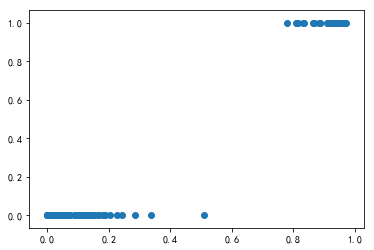

In [9]:
import matplotlib.pyplot as plt
plt.scatter(outputs.cpu().detach().numpy(), scores.cpu().detach().numpy())
plt.show()

In [10]:
import pandas as pd
result = pd.read_json("result_rnn.json")

In [11]:
vpres = sentenceToVector(result["pre"], lang)
vnexts = sentenceToVector(result["make"], lang)

In [12]:
outputs = model(vpres, vnexts)
result["similarity"] = outputs.detach()

count    640.000000
mean       0.455207
std        0.363265
min        0.001302
25%        0.117984
50%        0.298804
75%        0.872962
max        0.987616
Name: similarity, dtype: float64


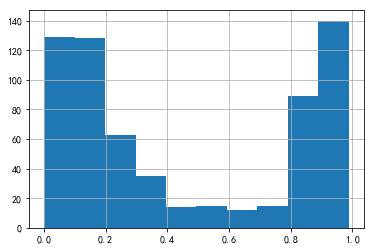

In [18]:
result["similarity"].hist()
print(result["similarity"].describe())
plt.show()

In [25]:
result.sort_values("similarity", ascending=False)[-50:]

,make,next,pre,similarity
374,He s rich,He s rich,Of the Manhattan Brombergs,0.987616
542,It would wreck us,It would wreck us,Look we can t go to court,0.984234
632,No I m not comfortable but that s the point right,No I m not comfortable but that s the point right,Are you sure you re comfortable with this,0.982328
152,He s looking over here Oh oh,He s looking over here Oh oh,And there s gonna be a ring on it soon,0.981524
105,What,What,T A T TAT,0.981497
98,Hey I got new car a Mini Cooper,Hey I got new car a Mini Cooper,No man I saw you after my small business on a ...,0.979054
446,No,No,Max is she dead,0.978972
27,Calvin s out,Calvin s out,In my old life I go to spin class and lunch wi...,0.977394
612,He s my father and I love him,He s my father and I love him,I will be because despite what everyone else m...,0.973243
79,Oh,Oh,You can come back in the morning,0.971400


In [24]:
pd.Series([1,2,4]).describe()

count    3.000000
mean     2.333333
std      1.527525
min      1.000000
25%      1.500000
50%      2.000000
75%      3.000000
max      4.000000
dtype: float64